[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://tinyurl.com/2dqlcmyd)

# Métricas de Evaluación y Encoding de Variables Categóricas (Regresión)

En este ejemplo se muestra como realizar la codificación de variables categóricas utilizando diferentes técnicas de encoding, así como, la interpretación de las metricas de evaluación de un modelo de regresión.

Al trabajar con datasets es común encontrar características categóricas (nominales u ordinales), que no es posible pasarlas directamente al modelo.

<a href="https://ai-ml-analytics.com/wp-content/uploads/2021/02/Encoding-1.png"><img src="https://ai-ml-analytics.com/wp-content/uploads/2021/02/Encoding-1.png" alt="Tipos de Encoding"  width="50%" border="2"></a>


Para este ejemplo se utilizará el dataset que presenta el desempeño de los estudiantes en examenes publicado en [Kaggle](https://www.kaggle.com/datasets/spscientist/students-performance-in-exams).

References: https://is.gd/LoFv0q

# 1. Descripción de la Información - Contexto

El conjunto de datos de rendimiento estudiantil en exámenes de Kaggle incluye las calificaciones de 1.000 estudiantes en matemáticas, lectura y escritura. Además, proporciona información demográfica y académica, como género, grupo étnico, nivel educativo de los padres, tipo de almuerzo y participación en un curso de preparación para exámenes.

Este proyecto tiene como objetivo preprocesar los datos y desarrollar un modelo de aprendizaje automático capaz de **predecir las calificaciones** de los estudiantes en función de sus características. Dado que las puntuaciones son valores continuos, el problema se aborda como una tarea de regresión en aprendizaje automático.

# 2. Importar Librerias

In [176]:
import os
import pandas as pd
import numpy as np

# Data visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# Machine learning
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error

In [177]:
# verificar si estamos en google colab
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

In [178]:
if IN_COLAB:
    # download a folder from github
    !wget -O datasets.zip https://github.com/DiegoPaezA/CienciaDatos-MASDI/archive/refs/heads/main.zip
    !unzip datasets.zip
    !mv CienciaDatos-MASDI-main/datasets datasets_github
    !rm -rf datasets.zip CienciaDatos-MASDI-main

# 3. Importar y leer el dataset

In [179]:
# Obtener el directorio raíz del proyecto
dir_root = os.path.dirname(os.getcwd())
datasets_folder_name = 'content/datasets_github' if IN_COLAB else 'datasets'
ruta_dataset = os.path.join(dir_root, datasets_folder_name, 'regression', 'StudentsPerformance.csv')
# Cargamos el dataset
data = pd.read_csv(ruta_dataset)
data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


## Descripción del Dataset: Students Performance in Exams

El conjunto de datos **Students Performance in Exams** recopila información sobre el desempeño académico de 1.000 estudiantes en tres asignaturas: matemáticas, lectura y escritura. Además, incluye detalles demográficos y académicos relevantes. A continuación se describen las columnas presentes en el conjunto de datos:

- **gender**: Género del estudiante. Los valores posibles son:
  - `female`: Femenino.
  - `male`: Masculino.

- **race/ethnicity**: Grupo étnico al que pertenece el estudiante, categorizado como:
  - `group A`, `group B`, `group C`, `group D`, `group E`.

- **parental level of education**: Nivel educativo más alto alcanzado por los padres del estudiante. Ejemplos de valores:
  - `bachelor's degree`: Título universitario.
  - `some college`: Algún curso universitario.
  - `master's degree`: Maestría.
  - `high school`: Escuela secundaria.
  - `some high school`: Algo de educación secundaria.

- **lunch**: Tipo de almuerzo recibido por el estudiante:
  - `standard`: Almuerzo estándar.
  - `free/reduced`: Almuerzo gratuito o a precio reducido.

- **test preparation course**: Indica si el estudiante completó un curso de preparación para el examen:
  - `completed`: Curso completado.
  - `none`: No completado.

- **math score**: Calificación obtenida por el estudiante en matemáticas (valor numérico).

- **reading score**: Calificación obtenida por el estudiante en lectura (valor numérico).

- **writing score**: Calificación obtenida por el estudiante en escritura (valor numérico).

Este conjunto de datos es útil para analizar cómo factores demográficos y académicos influyen en el rendimiento de los estudiantes en diferentes áreas de conocimiento.


# 4. Datos perdidos y tipo de datos

In [180]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


In [181]:
data.dtypes.value_counts()

object    5
int64     3
Name: count, dtype: int64

De la información anterior, se puede observar que el dataset no presenta datos perdidos y que se cuenta con:

- 5 variables categóricas: `gender`, `race/ethnicity`, `parental level of education`, `lunch`, `test preparation course`.
- 3 variables numéricas: `math score`, `reading score`, `writing score`.

Adicionalmente se observa que no hay una variable objetivo definida, por lo tanto procederemos a analizar las variables numéricas para definir una variable objetivo.

# 5. Crear una variable Objetivo

Primero, se observa el comportamiento de las calificaciones que tienen los estudiantes en las diferentes materias. Para ello, se realiza un análisis descriptivo de las variables numéricas.

In [182]:
score = data[['math score', 'reading score', 'writing score']]
score.head()

,math score,reading score,writing score
0,72,72,74
1,69,90,88
2,90,95,93
3,47,57,44
4,76,78,75


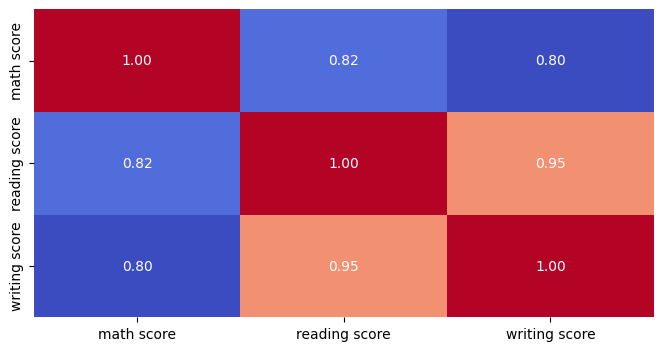

In [183]:
# Correlation between test scores
plt.figure(figsize = (8, 4))
correlation = score.corr()
sns.heatmap(correlation, annot = True, fmt = '.2f', cmap = 'coolwarm', cbar = False)
plt.show()

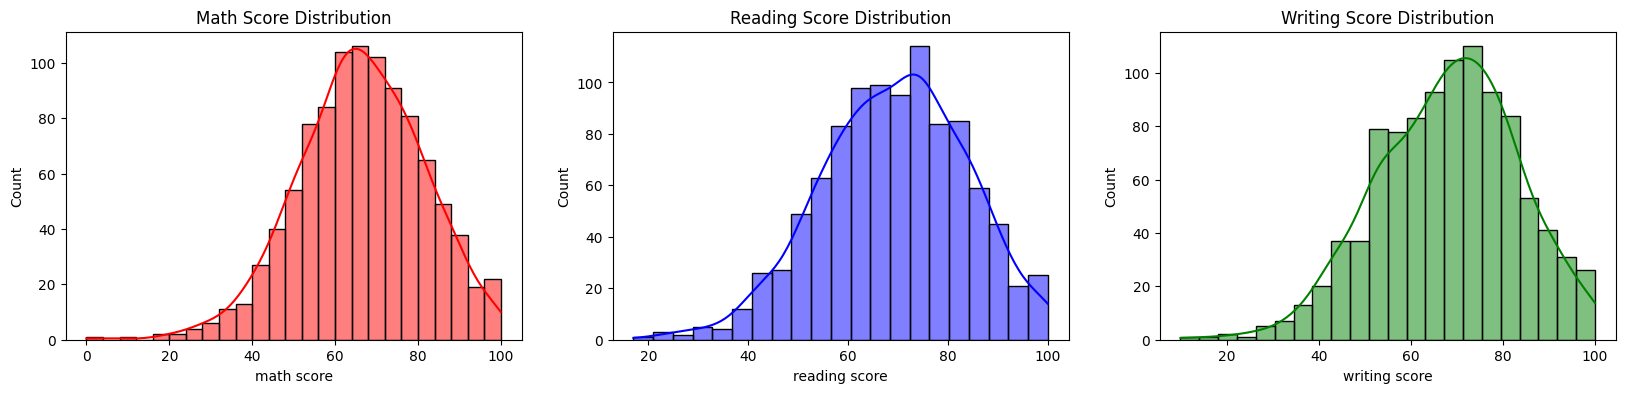

In [184]:
# Distribution of test scores 
plt.figure(figsize = (20, 4))
plt.subplot(1, 3, 1)
sns.histplot(data['math score'], kde = True, color = 'red')
plt.title('Math Score Distribution')
plt.subplot(1, 3, 2)
sns.histplot(data['reading score'], kde = True, color = 'blue')
plt.title('Reading Score Distribution')
plt.subplot(1, 3, 3)
sns.histplot(data['writing score'], kde = True, color = 'green')
plt.title('Writing Score Distribution')
plt.show()

**Conclusión:** Las calificaciones de los estudiantes presentan alta correlación entre sí, es decir, si un estudiante obtiene una calificación alta en matemáticas, es probable que también obtenga calificaciones altas en lectura y escritura. Adicionalmente, las calificaciones presentan una distribución normal, lo que tambien sugiere que los estudiantes obtienen calificaciones similares en las tres materias.

Por lo tanto, se crea una variable objetivo llamada `mean score` que representa el promedio de las calificaciones obtenidas por los estudiantes en matemáticas, lectura y escritura.

In [185]:
# Calculate average of all test results
data['mean score'] = score.mean(axis = 1)

# Drop math score, reading score and writing score
data = data.drop(['math score', 'reading score', 'writing score'], axis = 1)

# Show first 5 rows of new dataframe
data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,mean score
0,female,group B,bachelor's degree,standard,none,72.666667
1,female,group C,some college,standard,completed,82.333333
2,female,group B,master's degree,standard,none,92.666667
3,male,group A,associate's degree,free/reduced,none,49.333333
4,male,group C,some college,standard,none,76.333333


In [186]:
# Mean score data type
print("Mean score data type: ", data['mean score'].dtype)

Mean score data type:  float64


# 6. Analisis de datos Exploratorio

El análisis exploratorio de datos es el proceso de análisis y visualización de las variables de un conjunto de datos. Este paso no es necesario para la codificación de características, pero es util analizar los datos antes de aplicar cualquier técnica de aprendizaje automático.

## 6.1 Variables predictoras
Las variables predictoras del conjunto de datos son:

- Género
- Raza/etnia
- Nivel educativo de los padres
- Almuerzo
- Curso de preparación para el examen

En esta sección, exploraremos cómo estas diferentes características influyen en el resultado de la puntuación de un estudiante en el examen.

### 6.1.1 Gender


In [187]:
# Mean score by gender
data_gender = data[['gender', 'mean score']]
data_gender.head(10)

,gender,mean score
0,female,72.666667
1,female,82.333333
2,female,92.666667
3,male,49.333333
4,male,76.333333
5,female,77.333333
6,female,91.666667
7,male,40.666667
8,male,65.000000
9,female,49.333333


In [188]:
data['gender'].value_counts()

gender
female    518
male      482
Name: count, dtype: int64

Se puede observar que la variable género es de tipo categórica y presenta dos categorías: `female` y `male`. A continuación, se analiza cómo influye el género en la puntuación promedio de los estudiantes.

In [189]:
# se agrupan los datos por género y se calcula el promedio de las calificaciones
data_gender = data_gender.groupby('gender', as_index = False).mean().sort_values(by = 'mean score', ascending = False, ignore_index = True)
data_gender

,gender,mean score
0,female,69.569498
1,male,65.837483


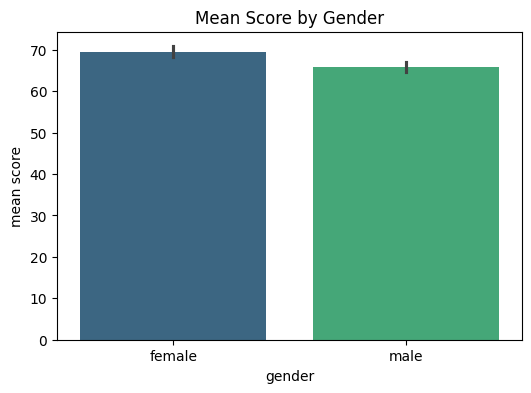

In [190]:
# Mean score by gender barplot
plt.figure(figsize = (6, 4))
sns.barplot(x = 'gender', y = 'mean score', data = data, palette = 'viridis')


plt.title('Mean Score by Gender')
plt.show()

**Conclusión:** Los estudiantes de género femenino obtienen una puntuación promedio más alta que los estudiantes de género masculino. Sin embargo, la diferencia en las puntuaciones no es significativa, lo que sugiere que el género no es un factor determinante en el rendimiento académico de los estudiantes.

### 6.1.2 Race/ethnicity

In [191]:
# Mean score by race/ethnicity
data_race = data[['race/ethnicity', 'mean score']].groupby('race/ethnicity', as_index = False).mean().sort_values(by = 'mean score', ascending = True, ignore_index = True)
data_race

,race/ethnicity,mean score
0,group A,62.992509
1,group B,65.468421
2,group C,67.131661
3,group D,69.179389
4,group E,72.752381


In [192]:
data_race.rename(columns={"race/ethnicity": "ethnicity", "mean score":"m_score"}, inplace=True)
data_race

,ethnicity,m_score
0,group A,62.992509
1,group B,65.468421
2,group C,67.131661
3,group D,69.179389
4,group E,72.752381


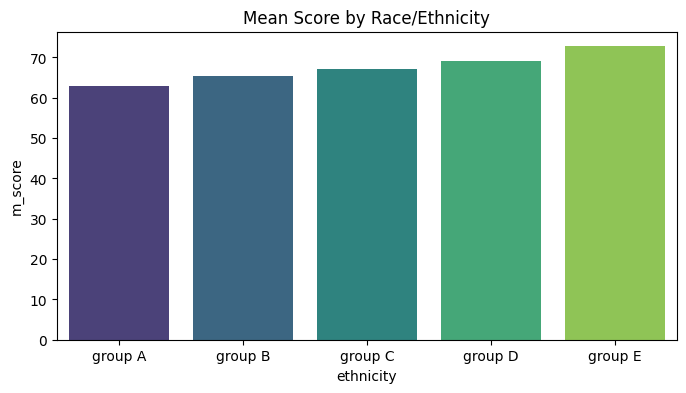

In [193]:
# Mean score by race/ethnicity barplot
plt.figure(figsize = (8, 4))
sns.barplot(data = data_race, x = 'ethnicity', y = 'm_score', order=data_race.sort_values('m_score').ethnicity, palette = 'viridis')
plt.title('Mean Score by Race/Ethnicity')
plt.show()

Parece haber una tendencia creciente en las puntuaciones medias de las pruebas a medida que pasamos del grupo A al grupo E, es decir, los alumnos del grupo A son los que obtienen peores resultados, mientras que los del grupo E son los que obtienen mejores resultados.

Sin embargo, a falta de más información, nos resulta difícil sacar alguna conclusión.

### 6.1.3 Nivel educativo de los padres

In [194]:
# Mean score by parental level of education
data_edu = data[['parental level of education', 'mean score']].groupby('parental level of education', as_index = False).mean().sort_values(by = 'mean score', ascending = True, ignore_index = True)

In [195]:
data_edu.rename(columns={"parental level of education": "level_edu", "mean score":"m_score"}, inplace=True)
data_edu

,level_edu,m_score
0,high school,63.096939
1,some high school,65.108007
2,some college,68.476401
3,associate's degree,69.569069
4,bachelor's degree,71.923729
5,master's degree,73.598870


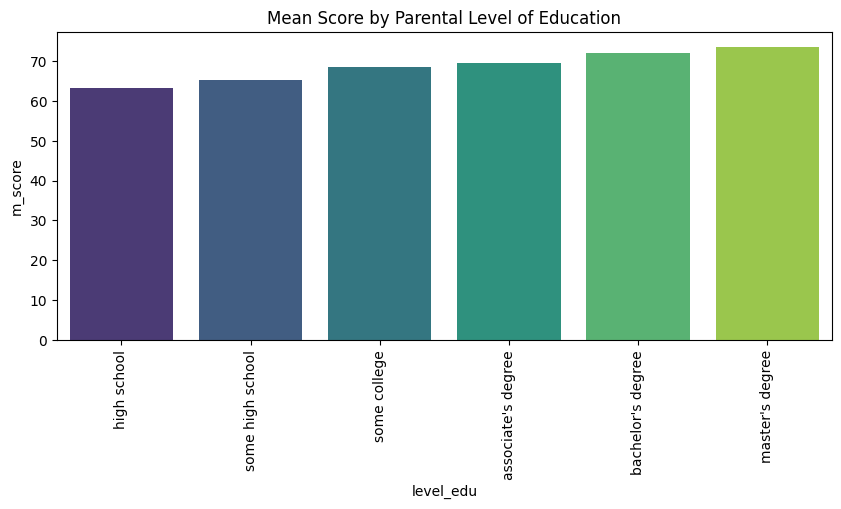

In [196]:
# Mean score by parental level of education barplot
plt.figure(figsize = (10, 4))
sns.barplot(data = data_edu, x = 'level_edu', y = 'm_score', order=data_edu.sort_values('m_score').level_edu, palette = 'viridis')
plt.title('Mean Score by Parental Level of Education')
plt.xticks(rotation = 90);
plt.show()

En su mayor parte, los resultados coinciden con lo que cabría esperar, es decir, que a medida que aumenta el nivel educativo de los padres, también aumenta la puntuación media en los exámenes de los estudiantes.

### 6.1.4 Almuerzo


In [197]:
# Mean score by lunch
data[['lunch', 'mean score']].groupby('lunch', as_index = False).mean().sort_values(by = 'mean score', ascending = False, ignore_index = True)

,lunch,mean score
0,standard,70.837209
1,free/reduced,62.199061


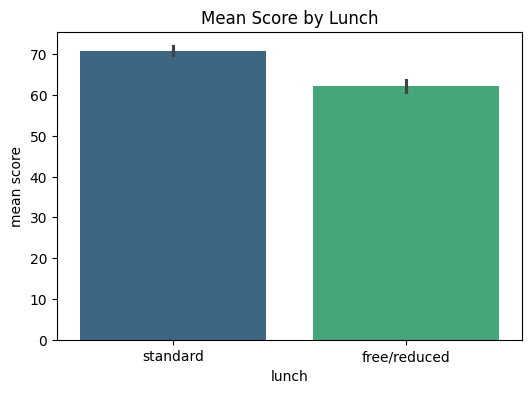

In [198]:
# Mean score by lunch barplot
plt.figure(figsize = (6, 4))
sns.barplot(x = 'lunch', y = 'mean score', data = data, palette = 'viridis')
plt.title('Mean Score by Lunch')
plt.show()

Los estudiantes con almuerzo estándar obtienen mejores resultados que los que tienen almuerzo gratuito/reducido.

El almuerzo puede considerarse un indicador de la situación económica de los alumnos. Por lo tanto, tiene sentido que los estudiantes que tienen una mejor situación económica tengan un mejor rendimiento escolar en comparación con los que tienen una peor situación económica, por término medio.

### 6.1.5 Curso de preparación de exámenes

In [199]:
# Mean score by test preparation course
data[['test preparation course', 'mean score']].groupby('test preparation course', as_index = False).mean().sort_values(by = 'mean score', ascending = False, ignore_index = True)

,test preparation course,mean score
0,completed,72.669460
1,none,65.038941


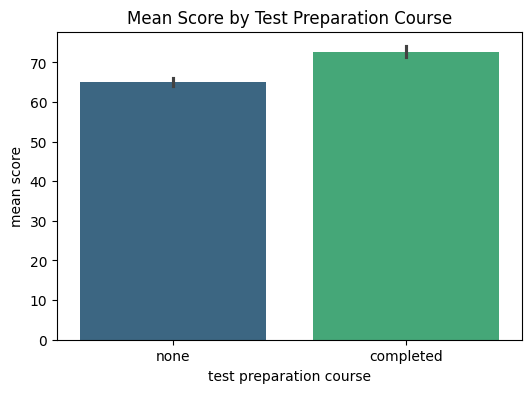

In [200]:
# Mean score by test preparation course barplot
plt.figure(figsize = (6, 4))
sns.barplot(x = 'test preparation course', y = 'mean score', data = data, palette = 'viridis')
plt.title('Mean Score by Test Preparation Course')
plt.show()

Esto no debería sorprender en absoluto. Cuanto más preparados estén los estudiantes para su examen, mejor será su rendimiento.

## 6.2 Target variable (mean score)


In [201]:
# Mean score summary statistics
data['mean score'].describe()

count    1000.000000
mean       67.770667
std        14.257326
min         9.000000
25%        58.333333
50%        68.333333
75%        77.666667
max       100.000000
Name: mean score, dtype: float64

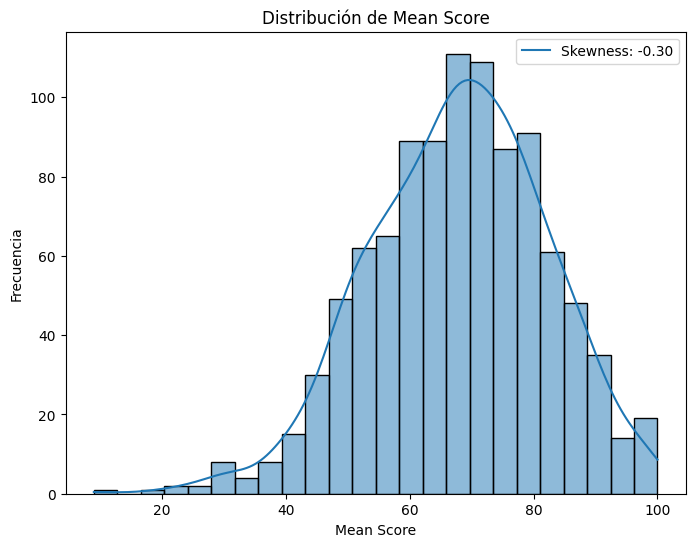

In [202]:
# Distribution of mean score
plt.figure(figsize=(8, 6))
sns.histplot(data['mean score'], kde=True)

# Añadir la etiqueta de skewness
skewness = data['mean score'].skew()
plt.legend([f'Skewness: {skewness:.2f}'])

plt.title('Distribución de Mean Score')
plt.xlabel('Mean Score')
plt.ylabel('Frecuencia')
plt.show()

La skewness (asimetría) es una medida de la simetría de la distribución de los datos. Indica si los datos están sesgados hacia la izquierda o hacia la derecha de la media.

Tipos de Skewness
1. Skewness positiva: La cola de la distribución se extiende más hacia la derecha. Los valores están sesgados hacia la izquierda.
2. Skewness negativa: La cola de la distribución se extiende más hacia la izquierda. Los valores están sesgados hacia la derecha.
3. Skewness cero: La distribución es simétrica.

# 7. Codificación de características

Ahora que hemos explorado por completo las variables del conjunto de datos, es momento de preparar los datos para el modelado.

Más concretamente, queremos convertir los datos categóricos de nuestro conjunto de datos en datos numéricos. Este proceso se conoce como codificación de características.

Pero antes de sumergirnos en la codificación de características, es importante que primero contrastemos la diferencia entre una variable nominal y una variable ordinal. Esto es para que podamos hacer coincidir el codificador correcto con la variable correcta.

**La variable nominal** es una variable categórica cuyos datos no tienen un orden lógico. Algunos ejemplos de datos nominales son

- Hombre y mujer
- Ubicación A, ubicación B y ubicación C

**La variable ordinal**, por otro lado, también es una variable categórica pero sus datos siguen un orden lógico. Algunos ejemplos de datos ordinales son:

- Pequeño, mediano y grande
- Malo, neutro y bueno
- Niños, adultos y ancianos
- Ingresos bajos, medios y altos

Como veremos en esta sección, las variables nominales se codifican con **OneHotEncoder**, mientras que las ordinales se codifican con **OrdinalEncoder**.

## 7.1 Codificación de las variables nominales

Las variables nominales de nuestro conjunto de datos incluyen:

- Género (Gender)
- Raza/etnia (Race/ethnicity)
- Almuerzo (Lunch)
- Curso de preparación para el examen (Test prepation course)


En esta sección, exploraremos dos formas diferentes de codificar las variables **nominales**, una utilizando el OneHotEncoder de Scikit-learn y la otra utilizando el get_dummies de Pandas.

### 7.1.1 Scikit-learn OneHotEncoder

El OneHotEncoder de Scikit-learn es una técnica de codificación de características que convierte las variables categóricas en un formato que puede ser proporcionado a los algoritmos de aprendizaje automático para mejorar el rendimiento del modelo. La codificación OneHot crea una columna binaria para cada categoría en la variable categórica. Si la variable categórica tiene n categorías, la codificación OneHot creará n columnas binarias.

**Remover la primera columna binaria**: Si se tiene n categorías, se deben crear n-1 columnas binarias. Esto se debe a que la columna restante se puede inferir de las otras n-1 columnas. Por lo tanto, se elimina una columna binaria para evitar la multicolinealidad.

In [203]:
# Instantiate OneHotEncoder
ohe = OneHotEncoder(sparse_output=False, drop='first')

In [204]:
# Apply OneHotEncoder to the gender column
ohe.fit_transform(data[['gender']])[:5]

array([[0.],
       [0.],
       [0.],
       [1.],
       [1.]])

In [205]:
# The first 5 rows the gender column for comparison
data['gender'].head()

0    female
1    female
2    female
3      male
4      male
Name: gender, dtype: object

In [206]:
# Gender categories in OneHotEncoder
ohe.categories_

[array(['female', 'male'], dtype=object)]

Como podemos ver, OneHotEncoder ha creado dos columnas para representar la característica de género en nuestro marco de datos, una para mujeres y otra para hombres.

Las estudiantes recibirán un valor de 1 en la columna de mujeres y 0 en la de hombres, mientras que los estudiantes varones recibirán un valor de 0 en la columna de mujeres y 1 en la de hombres.

Pero lo más importante es que OneHotEncoder ha transformado con éxito lo que originalmente era una variable categórica en una variable numérica.

### 7.1.3 Pandas get_dummies

In [207]:
# Pandas get_dummies approach
pd.get_dummies(data['gender']).head()

,female,male
0,True,False
1,True,False
2,True,False
3,False,True
4,False,True


Aunque ambos enfoques dan el mismo resultado, en general se prefiere OneHotEncoder a get_dummies por las siguientes razones:

- Con OneHotEncoder, nuestro dataframe original sigue teniendo el mismo tamaño y, por tanto, es más fácil de gestionar y explorar.

- OneHotEncoder puede incorporarse como parte de un pipeline en Scikit-learn mientras que get_dummies requiere un enfoque más manual para la codificación.

- Esto hace que OneHotEncoder sea más eficiente a la hora de transformar tanto el conjunto de entrenamiento como el conjunto de prueba.

- Con OneHotEncoder, podemos utilizar GridSearch para evaluar y elegir los parámetros de preprocesamiento.

- Las puntuaciones de validación cruzada (Cross-validation scores) son más fiables con OneHotEncoder que con get_dummies.

Más adelante exploraremos la idea de construir un pipeline de aprendizaje automático.

## 7.2 Codificación de la variable ordinal

La única variable ordinal en nuestro conjunto de datos es la característica del **nivel de educación de los padres**.

En esta sección, consideraremos de nuevo dos enfoques para codificar la variable ordinal, uno utilizando Scikit-learn OrdinalEncoder mientras que el otro utilizando el método de mapa de Pandas.

### 7.2.1 OrdinalEncoder de Scikit-learn
OrdinalEncoder se diferencia de OneHotEncoder en que asigna valores incrementales a valores únicos en una variable ordinal en lugar de sólo 0 y 1.

Esto ayuda a los modelos de aprendizaje automático a reconocer una variable ordinal y a utilizar posteriormente la información que ha aprendido para hacer predicciones más precisas.

Veamos ahora cómo podemos codificar la característica nivel de educación de los padres utilizando OrdinalEncoder.

In [208]:
# Unique values in the parental level of education column
list(data['parental level of education'].unique())

["bachelor's degree",
 'some college',
 "master's degree",
 "associate's degree",
 'high school',
 'some high school']

Es importante que especifiquemos el orden de una variable ordinal. Para nuestra característica de nivel de educación de los padres, queremos que el orden sea el siguiente:

- Some high school
- High school
- Some college
- Associate's degree
- Bachelor's degree
- Master's degree

In [209]:
# Specify the order for the level of education
education_categories = ['some high school', 'high school', 'some college', "associate's degree", "bachelor's degree", "master's degree"]

In [210]:
# Instantiate ordinal encoder
oe = OrdinalEncoder(categories = [education_categories])

In [211]:
# Apply ordinal encoder to parental level of education column
oe.fit_transform(data[['parental level of education']])[:5]

array([[4.],
       [2.],
       [5.],
       [3.],
       [2.]])

In [212]:
# First 5 rows of parental level of education for comparison
data['parental level of education'].head()

0     bachelor's degree
1          some college
2       master's degree
3    associate's degree
4          some college
Name: parental level of education, dtype: object

Obsérvese que **OrdinalEncoder** ha asignado el valor 0 a alguna escuela secundaria, 1 a la escuela superior, 2 a alguna universidad, 3 al grado de asociado, 4 a la licenciatura y, por último, 5 a la maestría.

### 7.2.2 Método del mapa de Pandas
El método de mapa de Pandas es un enfoque más manual para la codificación de variables ordinales. Aunque replica el resultado del OrdinalEncoder, no es ideal para codificar variables ordinales con un alto número de valores únicos.

In [213]:
# Pandas map method
data['parental level of education'].map({'some high school': 0,
                                        'high school': 1,
                                        'some college': 2,
                                        "associate's degree": 3,
                                        "bachelor's degree": 4,
                                        "master's degree": 5}).head()

0    4
1    2
2    5
3    3
4    2
Name: parental level of education, dtype: int64

## 7.3 Hacer transformador de columnas (column transformer)

Para el resto de este Colab, sólo consideraremos **OneHotEncoder** y **OrdinalEncoder** como métodos para codificar las variables categóricas en nuestro conjunto de datos.

En esta sección, combinaremos **OneHotEncoder** y **OrdinalEncoder** en un transformador de columnas de un solo paso utilizando el método `make_column_transformer` de la biblioteca **scikit-learn**.

### ¿Qué es `make_column_transformer`?

El método `make_column_transformer` es una función de **scikit-learn** que facilita la creación de un transformador de columnas de manera concisa y estructurada. Permite aplicar diferentes transformaciones a diferentes columnas del conjunto de datos, todo en un solo objeto transformador. Este enfoque es particularmente útil cuando el conjunto de datos contiene una combinación de columnas categóricas y numéricas que requieren diferentes tipos de preprocesamiento.

### Principales ventajas de `make_column_transformer`:

1. **Facilidad de uso**: Permite especificar qué transformador aplicar a cada conjunto de columnas, reduciendo la complejidad del código.
2. **Flexibilidad**: Soporta múltiples tipos de transformaciones, incluyendo encoders (como `OneHotEncoder` y `OrdinalEncoder`), escaladores (`StandardScaler`, `MinMaxScaler`) y más.
3. **Pipeline compatible**: El transformador resultante se puede integrar fácilmente en un pipeline de aprendizaje automático de **scikit-learn**.
4. **Manejo automático de columnas no especificadas**: Permite configurar cómo se manejan las columnas que no están explícitamente incluidas en el transformador.

### Ejemplo práctico:

A continuación, se muestra un ejemplo de cómo crear un transformador de columnas que aplique `OneHotEncoder` a algunas columnas categóricas y `OrdinalEncoder` a otras:

```python
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

# Definimos las columnas y sus transformadores
column_transformer = make_column_transformer(
    (OneHotEncoder(), ['column_a', 'column_b']),  # Aplicar OneHotEncoder a column_a y column_b
    (OrdinalEncoder(), ['column_c']),            # Aplicar OrdinalEncoder a column_c
    remainder='passthrough'                      # Las columnas no especificadas se dejan sin transformar
)

# Ajuste del transformador al conjunto de datos
column_transformer.fit(X_train)

# Transformación de los datos
X_train_transformed = column_transformer.transform(X_train)
X_test_transformed = column_transformer.transform(X_test)
```

In [214]:
# Get predictor variables and target variable from data
X = data.drop('mean score', axis = 1)
y = data['mean score']

In [215]:
X

,gender,race/ethnicity,parental level of education,lunch,test preparation course
0,female,group B,bachelor's degree,standard,none
1,female,group C,some college,standard,completed
2,female,group B,master's degree,standard,none
3,male,group A,associate's degree,free/reduced,none
4,male,group C,some college,standard,none
...,...,...,...,...,...
995,female,group E,master's degree,standard,completed
996,male,group C,high school,free/reduced,none
997,female,group C,high school,free/reduced,completed
998,female,group D,some college,standard,completed


In [216]:
# Make column transformer which consists of OneHotEncoder and OrdincalEncoder
column_transform = make_column_transformer(
    (ohe, ['gender', 'race/ethnicity', 'lunch', 'test preparation course']),
    (oe, ['parental level of education']))

In [217]:
# Apply column transformer to predictor variables
column_transform.fit_transform(X)[:5]

array([[0., 1., 0., 0., 0., 1., 1., 4.],
       [0., 0., 1., 0., 0., 1., 0., 2.],
       [0., 1., 0., 0., 0., 1., 1., 5.],
       [1., 0., 0., 0., 0., 0., 1., 3.],
       [1., 0., 1., 0., 0., 1., 1., 2.]])

# 8. Construir una cadena (pipeline) de aprendizaje automático

Una **cadena de aprendizaje automático** (pipeline) permite encadenar múltiples pasos del proceso de aprendizaje automático, donde la salida de cada paso se utiliza como entrada para el siguiente. Este enfoque es especialmente útil para combinar el preprocesamiento de datos y el modelado en un flujo de trabajo estructurado y cohesivo, asegurando que todas las transformaciones y ajustes se realicen de manera consistente durante el entrenamiento y la evaluación.

### Ventajas de utilizar pipelines:

1. **Eficiencia**: Simplifican el flujo de trabajo al unificar los pasos en un solo objeto.
2. **Evitan fugas de datos**: Garantizan que las transformaciones del preprocesamiento solo utilicen datos del conjunto de entrenamiento durante el ajuste.
3. **Reproducibilidad**: Facilitan la replicación del proceso completo con nuevos datos.
4. **Compatibilidad**: Se integran fácilmente con herramientas de validación cruzada y búsqueda de hiperparámetros en **scikit-learn**.

In [218]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (700, 5)
y_train shape:  (700,)
X_test shape:  (300, 5)
y_test shape:  (300,)


In [219]:
# Crear el pipeline nombrando los pasos
lm_pipeline = Pipeline([
    ('preprocessor', column_transform),  # Paso de preprocesamiento
    ('model', LinearRegression())          # Modelo de regresión lineal
])

In [220]:
lm_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['gender', 'race/ethnicity',
                                                   'lunch',
                                                   'test preparation course']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['some '
                                                                              'high '
                                                                              'school',
                                                                              'high '
                                                                              'school',
                                                                              'some '
                                                                              'college',
                                                                              "associate's "
                                                                              'degree',
                                                                              "bachelor's "
                                                                              'degree',
                                                                              "master's "
                                                                              'degree']]),
                                                  ['parental level of '
                                                   'education'])])),
                ('model', LinearRegression())])

In [221]:
gbm_pipeline = Pipeline([
    ('preprocessor', column_transform),  # Paso de preprocesamiento
    ('model', GradientBoostingRegressor())          # Modelo de regresión lineal
])

In [ ]:
# import random forest regressor
from sklearn.ensemble import RandomForestRegressor

rf_pipeline = Pipeline([
    ('preprocessor', column_transform),  # Paso de preprocesamiento
    ('model', RandomForestRegressor())          # Modelo de regresión lineal
])

In [ ]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=10)
xgb_model_pipeline = Pipeline([
    ('preprocessor', column_transform),  # Paso de preprocesamiento
    ('model', xgb_model)          # Modelo de regresión lineal
])

In [ ]:
# Fit pipeline to training set and make predictions on test set
lm_pipeline.fit(X_train, y_train)
lm_predictions = lm_pipeline.predict(X_test)
print("First 5 LM predictions: ", list(lm_predictions[:5]))

gbm_pipeline.fit(X_train, y_train)
gbm_predictions = gbm_pipeline.predict(X_test)
print(f"First 5 GBM predictions: {[round(elem, 3) for elem in list(gbm_predictions[:5])]}")

rf_pipeline.fit(X_train, y_train)
rf_predictions = rf_pipeline.predict(X_test)
print(f"First 5 RF predictions: {[round(elem, 3) for elem in list(rf_predictions[:5])]}")


xgb_model_pipeline.fit(X_train, y_train)
xgb_predictions = xgb_model_pipeline.predict(X_test)

First 5 LM predictions:  [70.75915726738543, 66.2105724106489, 71.20605482276783, 56.83267580456891, 78.06510895753397]
First 5 GBM predictions: [69.727, 72.455, 68.429, 58.834, 76.618]
First 5 RF predictions: [67.332, 69.332, 64.198, 62.581, 75.873]


In [235]:
# Calculate mean square error and root mean squared error
lm_mae = mean_absolute_error(y_true=y_test, y_pred=lm_predictions)
lm_rmse =  np.sqrt(mean_squared_error(y_true=y_test, y_pred=lm_predictions))
lm_r2 = r2_score(y_true=y_test, y_pred=lm_predictions)

gbm_mae = mean_absolute_error(y_true=y_test, y_pred=gbm_predictions)
gbm_rmse =  np.sqrt(mean_squared_error(y_true=y_test, y_pred=gbm_predictions))
gbm_r2 = r2_score(y_true=y_test, y_pred=gbm_predictions)

rf_mae = mean_absolute_error(y_true=y_test, y_pred=rf_predictions)
rf_rmse =  np.sqrt(mean_squared_error(y_true=y_test, y_pred=rf_predictions))
rf_r2 = r2_score(y_true=y_test, y_pred=rf_predictions)

xgb_mae = mean_absolute_error(y_true=y_test, y_pred=xgb_predictions)
xgb_rmse =  np.sqrt(mean_squared_error(y_true=y_test, y_pred=xgb_predictions))
xgb_r2 = r2_score(y_true=y_test, y_pred=xgb_predictions)

In [236]:
# create a dictionary of results
results = {'Linear Regression': [lm_mae, lm_rmse, lm_r2],
            'Gradient Boosting Regressor': [gbm_mae, gbm_rmse, gbm_r2],
            'Random Forest Regressor': [rf_mae, rf_rmse, rf_r2],
            'XGBoost Regressor': [xgb_mae, xgb_rmse, xgb_r2]}
results_df = pd.DataFrame(results, index = ['Mean Absolute Error', 'Root Mean Squared Error', 'R2 Score'])
results_df

,Linear Regression,Gradient Boosting Regressor,Random Forest Regressor,XGBoost Regressor
Mean Absolute Error,10.486951,10.888035,12.109195,11.697225
Root Mean Squared Error,13.141177,13.688265,15.092326,14.685761
R2 Score,0.233965,0.168855,-0.010398,0.043306


# 9. Análisis de las métricas de evaluación


### **1. Error Medio Absoluto (MAE):**
- El **MAE** indica el error promedio absoluto en las predicciones.
- La **Regresión Lineal** tiene el menor MAE (10.52), lo que implica que, en promedio, las predicciones están a unos 10 puntos de los valores reales.
- **Random Forest** tiene el peor MAE (12.11), lo que confirma su menor desempeño.


### **2. Raíz del Error Medio Cuadrático (RMSE):**
- El **RMSE** penaliza más los errores grandes. Un RMSE más bajo implica un mejor ajuste.
- Nuevamente, la **Regresión Lineal** tiene el mejor desempeño (13.16), seguida de **Gradient Boosting** (13.78), mientras que **Random Forest** tiene el RMSE más alto (15.17), reflejando errores significativos en algunas predicciones.


### **3. Coeficiente de Determinación (\( R^2 \)):**
- **Regresión Lineal (\( R^2 = 0.231 \))**:
  - Explica el 23.1% de la variabilidad en los datos. Aunque es bajo, indica que este modelo captura algo de la relación entre las características y la variable objetivo.

- **Gradient Boosting (\( R^2 = 0.158 \))**:
  - Explica solo el 15.8% de la variabilidad, lo cual es peor que la Regresión Lineal, probablemente debido a un subajuste o una mala configuración de hiperparámetros.

- **Random Forest (\( R^2 = -0.021 \))**:
  - Un \( R^2 \) negativo indica que el modelo no está capturando la relación en absoluto, y está rindiendo peor que simplemente predecir el promedio.



## Figura: Predicciones vs Valores Reales

La figura muestra la relación entre los valores reales de la variable objetivo (eje X) y las predicciones realizadas por tres modelos de aprendizaje automático (eje Y): **Regresión Lineal**, **Gradient Boosting**, y **Random Forest**. 

La línea roja discontinua representa la línea ideal donde las predicciones serían exactamente iguales a los valores reales 

$y_{\text{real}}$ = $y_{\text{pred}}$.

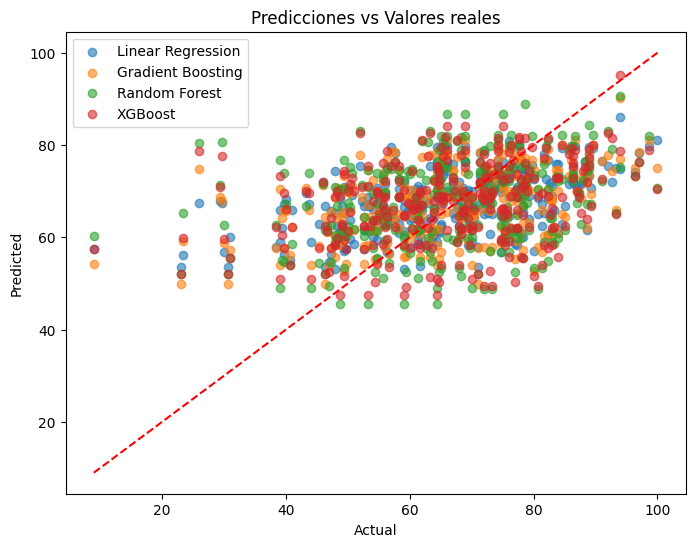

In [237]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, lm_predictions, label='Linear Regression', alpha=0.6)
plt.scatter(y_test, gbm_predictions, label='Gradient Boosting', alpha=0.6)
plt.scatter(y_test, rf_predictions, label='Random Forest', alpha=0.6)
plt.scatter(y_test, xgb_predictions, label='XGBoost', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.title('Predicciones vs Valores reales')
plt.show()

### **Ejes de la gráfica**:
- **Eje X (Actual)**: Representa los valores reales de la variable objetivo $y_{\text{real}}$, tomados del conjunto de prueba.
- **Eje Y (Predicted)**: Representa los valores predichos por cada modelo.

### **Elementos principales de la figura**:
1. **Puntos de dispersión (scatter plots)**:
   - Cada punto representa un par (valor real, valor predicho) para uno de los modelos:
     - **Azul**: Predicciones de Regresión Lineal.
     - **Naranja**: Predicciones de Gradient Boosting.
     - **Verde**: Predicciones de Random Forest.

2. **Línea roja discontinua**:
   - Esta línea (\( y = x \)) representa las predicciones perfectas. Si un modelo predijera con total precisión, todos los puntos estarían alineados en esta línea.



### **Cómo leer la gráfica**:
1. **Precisión de los modelos**:
   - Cuanto más cerca están los puntos de la línea roja, mejor es el desempeño del modelo.
   - En la figura, los puntos están dispersos alrededor de la línea, lo que indica errores significativos en las predicciones de todos los modelos.

2. **Diferencias entre modelos**:
   - **Regresión Lineal** tiene una leve ventaja, con puntos más cercanos a la línea roja en comparación con Gradient Boosting y Random Forest.
   - **Random Forest** muestra una mayor dispersión, especialmente en los valores extremos, reflejando su menor rendimiento.

3. **Errores sistemáticos**:
   - Para valores reales bajos $y_{\text{real}}<40$, los modelos tienden a **sobreestimar** las predicciones (predicciones más altas que los valores reales).
   - Para valores reales altos $y_{\text{real}} > 80$, los modelos tienden a **subestimar** las predicciones (predicciones más bajas que los valores reales).


### **Observaciones destacadas**:
- **Regresión Lineal** muestra un desempeño consistente pero limitado $R^2 = 0.231$.
- **Gradient Boosting** tiene un comportamiento similar, pero con un ajuste ligeramente peor $R^2 = 0.158$.
- **Random Forest** presenta un mal desempeño general $R^2 = -0.021$, con puntos muy alejados de la línea roja.




# 10. Conclusión
En resumen, en este colab hemos aprendido la diferencia entre una variable nominal y una variable ordinal, así como la forma de codificarlas correctamente utilizando Scikit-learn OneHotEncoder y LabelEncoder.

También hemos analizado las ventajas de realizar la codificación de características utilizando la biblioteca Scikit-learn en lugar de la biblioteca Pandas, es decir, la flexibilidad para encadenar el preprocesamiento de datos junto con un modelo de aprendizaje automático para formar un conducto de aprendizaje automático cohesivo.

Con respecto a la evaluación de los modelos de regresión, hemos observado lo siguiente:

- Ninguno de los modelos logra capturar completamente la relación entre las características y la variable objetivo.
- La dispersión de los puntos sugiere que las relaciones en los datos pueden ser complejas, lo que requiere:
  1. Refinar las características utilizadas.
  2. Optimizar los hiperparámetros de los modelos no lineales como Gradient Boosting y Random Forest.
  3. Explorar si hay ruido o valores atípicos que puedan estar afectando las predicciones.

## **Lecciones clave**:

Si la variable objetivo fue creada a partir de otras variables, este proceso puede introducir ciertas limitaciones que afecten el rendimiento del modelo.

#### **Problemas comunes al crear una variable objetivo**:

1. **Relaciones indirectas**:
   - Si la variable objetivo es una combinación de otras variables que no están directamente relacionadas con las características predictoras, esto puede dificultar el aprendizaje del modelo.
   - Por ejemplo, si la variable objetivo es un promedio de puntuaciones, pero las características predictoras no tienen una relación directa con todas las componentes del promedio, los modelos tendrán problemas para ajustarse correctamente.

2. **Sesgo en la agregación**:
   - Si el proceso de creación introduce sesgos (e.g., promedios ponderados, exclusión de valores extremos), esto puede alterar la relación entre la variable objetivo y las características, limitando la capacidad del modelo para capturar patrones reales en los datos.

3. **Falta de variabilidad**:
   - Si la variable creada reduce la variabilidad de los datos originales (e.g., al promediar), los modelos podrían tener menos información para diferenciar casos, lo que puede resultar en un ajuste deficiente.


# 11. Actividades Futuras Recomendadas

Basado en el análisis previo, aquí se propone una lista de actividades futuras para mejorar el desempeño del modelo y validar las relaciones en el dataset:

### **1. Usar una variable original como objetivo**
- Selecciona una de las variables originales del dataset (e.g., "math score", "reading score", "writing score") como la nueva variable objetivo.
- Esto elimina el sesgo y la pérdida de información asociada con la creación de una variable promedio.

### **2. Evaluar la correlación entre características y la variable objetivo**
- Realiza un análisis de correlación para identificar qué variables tienen una relación significativa con la variable objetivo seleccionada.
- Elimina o transforma características con correlaciones bajas o irrelevantes.

### **3. Implementar transformaciones para la variable objetivo**
- Si la variable objetivo tiene una distribución asimétrica, prueba aplicar transformaciones como logaritmo (`np.log1p`) o raíz cuadrada (`np.sqrt`) para reducir la asimetría.

### **4. Incrementar la variabilidad de las características**
- Si la variable objetivo promedio fue creada como un agregado de las variables "math score", "reading score" y "writing score", considera usar las tres variables como objetivos independientes.
- Esto permitirá que los modelos exploren relaciones más directas entre las características y cada componente.

### **5. Incorporar nuevas características derivadas**
- Crea nuevas características a partir de las existentes, como interacciones entre variables (e.g., `math score * reading score`) o normalizaciones.

### **6. Ajustar hiperparámetros de los modelos complejos**
- Usa herramientas como `GridSearchCV` o `RandomizedSearchCV` para encontrar la mejor configuración de hiperparámetros para modelos como Gradient Boosting o Random Forest.

### **7. Dividir la predicción en segmentos**
- Si los datos presentan diferentes comportamientos en rangos específicos (e.g., valores bajos frente a altos), considera entrenar modelos separados para diferentes segmentos de la variable objetivo.

### **8. Validar el impacto del preprocesamiento**
- Prueba entrenar un modelo simple (e.g., Regresión Lineal) sin transformaciones para confirmar si el `ColumnTransformer` está afectando los resultados.
- Ajusta configuraciones como `OneHotEncoder` con `drop='first'` y verifica si las columnas transformadas tienen sentido.

### **9. Probar otros modelos**
- Explora modelos adicionales como:
  - **XGBoost** o **LightGBM** para datos no lineales.
  - **Support Vector Machines (SVR)** para relaciones complejas.

### **10. Implementar validación cruzada**
- Usa validación cruzada para evaluar los modelos de manera más robusta y evitar que los resultados dependan únicamente de una división específica del conjunto de datos.

### **11. Comparar con un modelo base**
- Utiliza un modelo base (`DummyRegressor`) para predecir la media y compara su desempeño con el de los modelos actuales. Si los resultados son similares, revisa la calidad de las características predictoras.

### **12. Evaluar métricas alternativas**
- Complementa el análisis con métricas como MAE (Mean Absolute Error) y MAPE (Mean Absolute Percentage Error), especialmente si el \( R^2 \) no es representativo del ajuste.



